In [1]:
# =========================
# Inference experiment (as requested):
# 1) Take ONE big image ~5000x5000 and its building mask
# 2) Resize the WHOLE image+mask by random factor z (same range as training)
# 3) True GSD after resize = GSD0 / z
# 4) Slide 256x256 windows with overlap, keep only windows with buildings (mask>0)
# 5) Predict GSD for each window, aggregate by MODE, compare with true GSD
# =========================

from google.colab import drive
drive.mount('/content/drive')

!pip -q install rasterio

import os, math, random
from typing import Tuple, Optional, Dict, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import rasterio
import matplotlib.pyplot as plt

# -------------------------
# Repro / device
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

Mounted at /content/drive
device: cuda


In [2]:
# =========================
# Unzip dataset from Google Drive
# =========================
ZIP_ON_DRIVE = "/content/drive/MyDrive/dataset.zip"
OUT_ZIP = "/content/dataset.zip"
OUT_DIR = "/content/dataset"

assert os.path.exists(ZIP_ON_DRIVE), f"Dataset zip not found on Drive: {ZIP_ON_DRIVE}"

# Copy zip to local (faster unzip)
!cp -v "{ZIP_ON_DRIVE}" "{OUT_ZIP}"
!mkdir -p "{OUT_DIR}"
!unzip -q "{OUT_ZIP}" -d "{OUT_DIR}"
print("dataset dir:", OUT_DIR)

IMG_DIR  = os.path.join(OUT_DIR, "images")
MASK_DIR = os.path.join(OUT_DIR, "gt")

assert os.path.isdir(IMG_DIR),  f"Missing images dir: {IMG_DIR}"
assert os.path.isdir(MASK_DIR), f"Missing gt dir: {MASK_DIR}"

'/content/drive/MyDrive/dataset.zip' -> '/content/dataset.zip'
dataset dir: /content/dataset


In [3]:
# =========================
# CONFIG
# =========================
GSD0_M_PER_PX = 0.30

# Model checkpoint
GSD_CKPT_PATH = "/content/drive/MyDrive/Models/best_gsd.pt"  # or last_gsd.pt
assert os.path.exists(GSD_CKPT_PATH), f"Checkpoint not found: {GSD_CKPT_PATH}"

# Select which big image to use:
# - If BIG_IMAGE_NAME is set -> use that file
# - Else -> automatically pick the largest (by area) image from images/
BIG_IMAGE_NAME: Optional[str] = None   # e.g. "scene_001.tif"

# Resize factor z sampling (same as training)
Z_MIN, Z_MAX = 0.25, 1.5
Z_LOG_UNIFORM = True
Z_POWER = 1.0

# Sliding windows
PATCH = 256
STRIDE = 128
MIN_BUILDING_PX = 1

# Inference
BATCH_SIZE = 32
CLAMP_LOG_MIN, CLAMP_LOG_MAX = -10.0, 10.0

# Mode estimation
BIN_WIDTH_LOG = None
MIN_PRED_FOR_MODE = 30

In [4]:
# =========================
# Utilities (match training normalization)
# =========================
IMG_EXTS = {".tif", ".tiff"}

def list_tifs(d: str) -> List[str]:
    out = []
    for fn in sorted(os.listdir(d)):
        if os.path.splitext(fn.lower())[1] in IMG_EXTS:
            out.append(os.path.join(d, fn))
    return out

def to_float01_hwc(img_hwc: np.ndarray) -> np.ndarray:
    if img_hwc.dtype == np.uint8:
        return img_hwc.astype(np.float32) / 255.0
    if img_hwc.dtype == np.uint16:
        return img_hwc.astype(np.float32) / 65535.0
    img = img_hwc.astype(np.float32)
    mx = np.nanmax(img)
    if mx > 1.5:
        img = img / (mx + 1e-6)
    return img

def ensure_3ch_chw(img_chw: np.ndarray) -> np.ndarray:
    if img_chw.shape[0] == 1:
        img_chw = np.repeat(img_chw, 3, axis=0)
    elif img_chw.shape[0] == 2:
        img_chw = np.concatenate([img_chw, img_chw[:1]], axis=0)
    elif img_chw.shape[0] > 3:
        img_chw = img_chw[:3]
    return img_chw

def sample_zoom(rng: random.Random, zmin: float, zmax: float, log_uniform: bool, power: float) -> float:
    zmin = float(zmin); zmax = float(zmax)
    u = rng.random()
    p = float(power)
    if p != 1.0:
        u = (u**p) / ((u**p) + ((1-u)**p) + 1e-12)
    if log_uniform:
        logz = math.log(zmin) + u * (math.log(zmax) - math.log(zmin))
        return float(math.exp(logz))
    return float(zmin + u * (zmax - zmin))

def mode_from_hist_log(values: np.ndarray,
                      bin_width_log: Optional[float] = None,
                      min_count: int = 1) -> Tuple[float, Dict]:
    v = values[np.isfinite(values)]
    v = v[v > 0]
    if v.size < max(min_count, 1):
        return float("nan"), {"n": int(v.size), "reason": "too_few"}

    logv = np.log(v)

    if bin_width_log is None:
        q1, q3 = np.percentile(logv, [25, 75])
        iqr = max(1e-6, (q3 - q1))
        h = 2.0 * iqr * (logv.size ** (-1/3))
        bin_width = float(max(h, 0.02))
    else:
        bin_width = float(bin_width_log)

    lo, hi = float(logv.min()), float(logv.max())
    if hi - lo < 1e-6:
        return float(np.exp(logv.mean())), {"n": int(v.size), "degenerate": True, "bin_width_log": bin_width}

    nbins = int(np.ceil((hi - lo) / bin_width))
    nbins = max(10, min(400, nbins))

    hist, edges = np.histogram(logv, bins=nbins, range=(lo, hi))
    k = int(hist.argmax())
    left, right = edges[k], edges[k + 1]
    in_bin = (logv >= left) & (logv < right)
    center = float(logv[in_bin].mean()) if in_bin.any() else float(0.5 * (left + right))

    return float(np.exp(center)), {
        "n": int(v.size),
        "bin_width_log": float(bin_width),
        "nbins": int(nbins),
        "modal_bin_idx": int(k),
        "modal_bin_count": int(hist[k]),
        "log_range": (lo, hi),
    }

In [5]:
# =========================
# Model (same as training)
# =========================
from torchvision.models import resnet50

class ResNet50GSDRegressor(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.encoder = resnet50(weights=None)
        self.encoder.fc = nn.Identity()

        self.enc0 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu)
        self.pool = self.encoder.maxpool
        self.enc1 = self.encoder.layer1
        self.enc2 = self.encoder.layer2
        self.enc3 = self.encoder.layer3
        self.enc4 = self.encoder.layer4

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        x0 = self.enc0(x)
        x1 = self.enc1(self.pool(x0))
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        z = self.gap(x4)
        t = self.head(z).squeeze(1)
        return {"t": t}

def load_gsd_ckpt(model: nn.Module, ckpt_path: str):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("model_state_dict", ckpt)
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
    model.load_state_dict(sd, strict=True)
    print(f"✅ Loaded checkpoint: {ckpt_path}")

model = ResNet50GSDRegressor(dropout=0.2).to(device)
load_gsd_ckpt(model, GSD_CKPT_PATH)
model.eval()

✅ Loaded checkpoint: /content/drive/MyDrive/Models/best_gsd.pt


ResNet50GSDRegressor(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [6]:
import os, random

OUT_DIR = "/content/dataset"
VAL_RATIO = 0.15

def list_pairs_simple(root):
    img_dir = os.path.join(root, "images")
    msk_dir = os.path.join(root, "gt")

    img_names = sorted([
        f for f in os.listdir(img_dir)
        if f.lower().endswith((".tif"))
    ])

    pairs = []
    for name in img_names:
        img_path = os.path.join(img_dir, name)
        msk_path = os.path.join(msk_dir, name)
        if os.path.exists(msk_path):
            pairs.append((img_path, msk_path))
    return pairs

def split_train_val(pairs, val_ratio=0.15, seed=42):
    rng = random.Random(seed)
    idxs = list(range(len(pairs)))
    rng.shuffle(idxs)
    n_val = max(1, int(len(pairs) * val_ratio))
    val_set = set(idxs[:n_val])
    train = [pairs[i] for i in range(len(pairs)) if i not in val_set]
    val   = [pairs[i] for i in range(len(pairs)) if i in val_set]
    return train, val

pairs = list_pairs_simple(OUT_DIR)
train_pairs, val_pairs = split_train_val(pairs, VAL_RATIO, SEED)

val_files = [os.path.basename(p[0]) for p in val_pairs]
print("VAL:", len(val_files))
print("\n".join(val_files[:50]))

VAL: 27
austin11.tif
austin21.tif
austin23.tif
austin27.tif
austin32.tif
austin4.tif
chicago1.tif
chicago15.tif
chicago25.tif
chicago31.tif
chicago32.tif
chicago36.tif
chicago4.tif
kitsap3.tif
kitsap30.tif
tyrol-w19.tif
tyrol-w2.tif
tyrol-w21.tif
tyrol-w23.tif
tyrol-w27.tif
vienna1.tif
vienna14.tif
vienna24.tif
vienna32.tif
vienna33.tif
vienna4.tif
vienna5.tif


In [7]:
# =========================
# Read ALL val images + masks (full)
# =========================

val_img_tensors  = []  # если хочешь сохранить img_t для всех val
val_mask_tensors = []  # если хочешь сохранить mask_t для всех val
val_meta         = []  # мета (имя, размеры) — удобно для дебага

assert len(val_pairs) > 0, "val_pairs is empty"

for IMG_PATH, MASK_PATH in val_pairs:
    # --- Read image ---
    with rasterio.open(IMG_PATH) as src:
        W, H = src.width, src.height
        bands = [1, 2, 3] if src.count >= 3 else list(range(1, src.count + 1))
        img_chw_raw = src.read(bands)  # CHW

    # --- Read mask ---
    with rasterio.open(MASK_PATH) as ms:
        mW, mH = ms.width, ms.height
        mask_raw = ms.read(1).astype(np.uint8)

    assert (W, H) == (mW, mH), f"Size mismatch for {os.path.basename(IMG_PATH)}: img=({W},{H}) mask=({mW},{mH})"
    print("Using:", os.path.basename(IMG_PATH), "| size:", (W, H), "| channels:", img_chw_raw.shape[0])

    # --- normalize like training ---
    img_hwc = np.transpose(img_chw_raw, (1, 2, 0))
    img_hwc = to_float01_hwc(img_hwc)
    img_chw = np.transpose(img_hwc, (2, 0, 1))
    img_chw = ensure_3ch_chw(img_chw)

    img_t  = torch.from_numpy(img_chw).float().unsqueeze(0)                 # [1,C,H,W]
    mask_t = torch.from_numpy(mask_raw).byte().unsqueeze(0).unsqueeze(0)    # [1,1,H,W]

    # --- optional: store ---
    val_img_tensors.append(img_t)
    val_mask_tensors.append(mask_t)
    val_meta.append({
        "name": os.path.basename(IMG_PATH),
        "W": W, "H": H,
        "C_raw": int(img_chw_raw.shape[0]),
        "bands_used": bands
    })

Using: austin11.tif | size: (5000, 5000) | channels: 3
Using: austin21.tif | size: (5000, 5000) | channels: 3
Using: austin23.tif | size: (5000, 5000) | channels: 3
Using: austin27.tif | size: (5000, 5000) | channels: 3
Using: austin32.tif | size: (5000, 5000) | channels: 3
Using: austin4.tif | size: (5000, 5000) | channels: 3
Using: chicago1.tif | size: (5000, 5000) | channels: 3
Using: chicago15.tif | size: (5000, 5000) | channels: 3
Using: chicago25.tif | size: (5000, 5000) | channels: 3
Using: chicago31.tif | size: (5000, 5000) | channels: 3
Using: chicago32.tif | size: (5000, 5000) | channels: 3
Using: chicago36.tif | size: (5000, 5000) | channels: 3
Using: chicago4.tif | size: (5000, 5000) | channels: 3
Using: kitsap3.tif | size: (5000, 5000) | channels: 3
Using: kitsap30.tif | size: (5000, 5000) | channels: 3
Using: tyrol-w19.tif | size: (5000, 5000) | channels: 3
Using: tyrol-w2.tif | size: (5000, 5000) | channels: 3
Using: tyrol-w21.tif | size: (5000, 5000) | channels: 3
Using

In [8]:
import os, gc
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import rasterio

# =========================
# Helpers
# =========================

@torch.no_grad()
def run_batch(batch: torch.Tensor) -> np.ndarray:
    batch = batch.to(device, non_blocking=True)
    t = model(batch)["t"]
    t = torch.clamp(t, CLAMP_LOG_MIN, CLAMP_LOG_MAX)
    gsd_hat = torch.exp(t).detach().float().cpu().numpy()
    return gsd_hat

def coords_for_shape(H: int, W: int, patch: int, stride: int):
    ys = list(range(0, H - patch + 1, stride))
    xs = list(range(0, W - patch + 1, stride))
    if (H - patch) % stride != 0:
        ys.append(H - patch)
    if (W - patch) % stride != 0:
        xs.append(W - patch)
    return [(x0, y0) for y0 in ys for x0 in xs]

def safe_abs_rel(est: float, true: float):
    if not np.isfinite(est) or est <= 0 or not np.isfinite(true) or true <= 0:
        return float("nan"), float("nan")
    abs_err = float(abs(est - true))
    rel_err = float(abs_err / (true + 1e-12) * 100.0)
    return abs_err, rel_err

# =========================
# Settings for scales (uniform in GSD)
# =========================
N_SCALES = 10
Z_MIN, Z_MAX = 0.25, 1

gsd_min = GSD0_M_PER_PX / Z_MAX  # best resolution
gsd_max = GSD0_M_PER_PX / Z_MIN  # worst resolution
gsd_grid = torch.linspace(gsd_min, gsd_max, steps=N_SCALES).tolist()

assert len(val_pairs) > 0, "val_pairs is empty"

# =========================
# Main loop: val images -> scales -> sliding windows -> stats
# =========================
records = []

for img_i, (IMG_PATH, MASK_PATH) in enumerate(val_pairs, start=1):
    name = os.path.basename(IMG_PATH)

    # --- read + normalize once per image ---
    with rasterio.open(IMG_PATH) as src:
        W, H = src.width, src.height
        bands = [1, 2, 3] if src.count >= 3 else list(range(1, src.count + 1))
        img_chw_raw = src.read(bands)  # CHW

    with rasterio.open(MASK_PATH) as ms:
        mW, mH = ms.width, ms.height
        mask_raw = ms.read(1).astype(np.uint8)

    assert (W, H) == (mW, mH), f"Size mismatch for {name}: img=({W},{H}) mask=({mW},{mH})"

    img_hwc = np.transpose(img_chw_raw, (1, 2, 0))
    img_hwc = to_float01_hwc(img_hwc)
    img_chw = np.transpose(img_hwc, (2, 0, 1))
    img_chw = ensure_3ch_chw(img_chw)

    img_t  = torch.from_numpy(img_chw).float().unsqueeze(0)              # [1,C,H,W]
    mask_t = torch.from_numpy(mask_raw).byte().unsqueeze(0).unsqueeze(0) # [1,1,H,W]

    print(f"\n=== VAL [{img_i:03d}/{len(val_pairs)}] {name} | base size=({W},{H}) ===")

    for scale_j, gsd_true in enumerate(gsd_grid, start=1):
        gsd_true = float(gsd_true)
        z = float(GSD0_M_PER_PX / gsd_true)

        newH = max(PATCH, int(round(H * z)))
        newW = max(PATCH, int(round(W * z)))

        # --- resize image (no storing) ---
        if z < 1.0:
            img_resized = F.interpolate(img_t, size=(newH, newW), mode="area")
            img_resample = "area"
        else:
            try:
                img_resized = F.interpolate(
                    img_t, size=(newH, newW), mode="bicubic",
                    align_corners=False, antialias=True
                )
            except TypeError:
                img_resized = F.interpolate(
                    img_t, size=(newH, newW), mode="bicubic",
                    align_corners=False
                )
            img_resample = "bicubic"

        img_resized = img_resized.squeeze(0).clamp(0, 1)  # [C,newH,newW]

        # --- resize mask ---
        mask_resized = (
            F.interpolate(mask_t.float(), size=(newH, newW), mode="nearest")
             .squeeze(0).squeeze(0).byte()
        )  # [newH,newW]

        # --- sliding windows ---
        coords = coords_for_shape(newH, newW, PATCH, STRIDE)
        kept, skipped = 0, 0

        wins = []
        pred_sum = 0.0
        pred_count = 0
        preds_for_median = []  # если предиктов очень много, это может быть тяжело

        # Чтобы медиана не взорвала память при огромном числе окон,
        # можно включить downsample (например, хранить не более 200k значений).
        MEDIAN_MAX_STORE = 200_000

        for (x0, y0) in coords:
            mwin = mask_resized[y0:y0+PATCH, x0:x0+PATCH]
            if int((mwin > 0).sum()) < MIN_BUILDING_PX:
                skipped += 1
                continue

            win = img_resized[:, y0:y0+PATCH, x0:x0+PATCH]
            if win.shape[1] != PATCH or win.shape[2] != PATCH:
                skipped += 1
                continue

            wins.append(win)
            kept += 1

            if len(wins) >= BATCH_SIZE:
                batch = torch.stack(wins, dim=0)
                gsd_hat = run_batch(batch).astype(np.float64).reshape(-1)

                # mean in streaming mode
                pred_sum += float(gsd_hat.sum())
                pred_count += int(gsd_hat.size)

                # median (store with cap)
                if pred_count <= MEDIAN_MAX_STORE:
                    preds_for_median.append(gsd_hat)
                wins = []

        if len(wins) > 0:
            batch = torch.stack(wins, dim=0)
            gsd_hat = run_batch(batch).astype(np.float64).reshape(-1)

            pred_sum += float(gsd_hat.sum())
            pred_count += int(gsd_hat.size)

            if pred_count <= MEDIAN_MAX_STORE:
                preds_for_median.append(gsd_hat)

        gsd_mean = (pred_sum / pred_count) if pred_count > 0 else float("nan")

        if pred_count > 0 and len(preds_for_median) > 0:
            gsd_all = np.concatenate(preds_for_median, axis=0)
            gsd_all = gsd_all[np.isfinite(gsd_all)]
            gsd_all = gsd_all[gsd_all > 0]
            gsd_median = float(np.median(gsd_all)) if gsd_all.size else float("nan")
        else:
            gsd_median = float("nan")

        abs_mean, rel_mean = safe_abs_rel(gsd_mean, gsd_true)
        abs_med,  rel_med  = safe_abs_rel(gsd_median, gsd_true)

        print(
            f"  [{scale_j:02d}/{N_SCALES}] z={z:.4f} | gsd_true={gsd_true:.6f} | "
            f"{img_resample} | size=({newW},{newH}) | kept={kept} | preds={pred_count}"
        )

        records.append({
            "image_idx": img_i,
            "image_name": name,
            "scale_idx": scale_j,
            "z": z,
            "gsd_true": gsd_true,
            "newW": newW,
            "newH": newH,
            "resample": img_resample,
            "kept_building_windows": kept,
            "skipped_windows": skipped,
            "pred_count": pred_count,

            # ONLY mean + median (no mode)
            "gsd_mean": gsd_mean,
            "abs_err_mean": abs_mean,
            "rel_err_mean_pct": rel_mean,

            "gsd_median": gsd_median,
            "abs_err_median": abs_med,
            "rel_err_median_pct": rel_med,

            # median storage note (for transparency)
            "median_stored_n": int(min(pred_count, 200_000)),
        })

        # free per-scale tensors
        del img_resized, mask_resized
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # free per-image tensors
    del img_t, mask_t, img_chw_raw, mask_raw, img_chw, img_hwc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# =========================
# Results tables
# =========================

df = pd.DataFrame(records)

# 1) Detailed table: image x scale
df_detail = (
    df.sort_values(["image_idx", "scale_idx"])
      .reset_index(drop=True)
)

# 2) Per-image summary across scales (mean/median of RELATIVE error across scales)
def finite_stats(s: pd.Series):
    s = s[np.isfinite(s)]
    if len(s) == 0:
        return pd.Series({"mean": np.nan, "median": np.nan, "count": 0})
    return pd.Series({"mean": float(s.mean()), "median": float(s.median()), "count": int(len(s))})

df_img_summary = (
    df.groupby(["image_idx", "image_name"])
      .agg(
          scales=("scale_idx", "count"),
          preds_total=("pred_count", "sum"),

          rel_err_mean_avg=("rel_err_mean_pct", lambda s: float(np.nanmean(s))),
          rel_err_mean_median=("rel_err_mean_pct", lambda s: float(np.nanmedian(s))),

          rel_err_median_avg=("rel_err_median_pct", lambda s: float(np.nanmean(s))),
          rel_err_median_median=("rel_err_median_pct", lambda s: float(np.nanmedian(s))),
      )
      .reset_index()
      .sort_values("image_idx")
)

# 3) Overall summary across ALL images & scales
overall = {
    "rel_err_mean_pct": finite_stats(df["rel_err_mean_pct"]),
    "rel_err_median_pct": finite_stats(df["rel_err_median_pct"]),
}

print("\n=== OVERALL RELATIVE ERROR (%) across ALL images+scales (valid only) ===")
print("MEAN  :", overall["rel_err_mean_pct"].to_dict())
print("MEDIAN:", overall["rel_err_median_pct"].to_dict())

display(df_detail)
display(df_img_summary)



=== VAL [001/27] austin11.tif | base size=(5000,5000) ===
  [01/10] z=1.0000 | gsd_true=0.300000 | area | size=(5000,5000) | kept=1178 | preds=1178
  [02/10] z=0.7500 | gsd_true=0.400000 | area | size=(3750,3750) | kept=700 | preds=700
  [03/10] z=0.6000 | gsd_true=0.500000 | area | size=(3000,3000) | kept=457 | preds=457
  [04/10] z=0.5000 | gsd_true=0.600000 | area | size=(2500,2500) | kept=321 | preds=321
  [05/10] z=0.4286 | gsd_true=0.700000 | area | size=(2143,2143) | kept=237 | preds=237
  [06/10] z=0.3750 | gsd_true=0.800000 | area | size=(1875,1875) | kept=190 | preds=190
  [07/10] z=0.3333 | gsd_true=0.900000 | area | size=(1667,1667) | kept=164 | preds=164
  [08/10] z=0.3000 | gsd_true=1.000000 | area | size=(1500,1500) | kept=121 | preds=121
  [09/10] z=0.2727 | gsd_true=1.100000 | area | size=(1364,1364) | kept=100 | preds=100
  [10/10] z=0.2500 | gsd_true=1.200000 | area | size=(1250,1250) | kept=81 | preds=81

=== VAL [002/27] austin21.tif | base size=(5000,5000) ===
  

,image_idx,image_name,scale_idx,z,gsd_true,newW,newH,resample,kept_building_windows,skipped_windows,pred_count,gsd_mean,abs_err_mean,rel_err_mean_pct,gsd_median,abs_err_median,rel_err_median_pct,median_stored_n
0,1,austin11.tif,1,1.000000,0.3,5000,5000,area,1178,343,1178,0.351539,0.051539,17.179503,0.349091,0.049091,16.363804,1178
1,1,austin11.tif,2,0.750000,0.4,3750,3750,area,700,141,700,0.415301,0.015301,3.825224,0.413336,0.013336,3.334027,700
2,1,austin11.tif,3,0.600000,0.5,3000,3000,area,457,72,457,0.510963,0.010963,2.192637,0.516156,0.016156,3.231227,457
3,1,austin11.tif,4,0.500000,0.6,2500,2500,area,321,40,321,0.614441,0.014441,2.406827,0.628392,0.028392,4.732013,321
4,1,austin11.tif,5,0.428571,0.7,2143,2143,area,237,19,237,0.709439,0.009438,1.348356,0.721416,0.021416,3.059455,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,27,vienna5.tif,6,0.375000,0.8,1875,1875,area,163,33,163,0.774321,0.025679,3.209901,0.765085,0.034915,4.364341,163
266,27,vienna5.tif,7,0.333333,0.9,1667,1667,area,144,25,144,0.852736,0.047264,5.251573,0.854046,0.045954,5.106015,144
267,27,vienna5.tif,8,0.300000,1.0,1500,1500,area,106,15,106,0.935668,0.064332,6.433168,0.943941,0.056059,5.605915,106
268,27,vienna5.tif,9,0.272727,1.1,1364,1364,area,90,10,90,0.994385,0.105615,9.601323,1.006886,0.093114,8.464916,90


,image_idx,image_name,scales,preds_total,rel_err_mean_avg,rel_err_mean_median,rel_err_median_avg,rel_err_median_median
0,1,austin11.tif,10,3549,5.893758,3.116026,5.744999,4.033020
1,2,austin21.tif,10,3260,4.694827,1.767873,5.034656,3.129168
2,3,austin23.tif,10,3607,12.547551,11.911600,11.909927,11.515406
3,4,austin27.tif,10,2810,7.062317,5.312998,7.927941,6.600777
4,5,austin32.tif,10,2528,8.410588,5.949923,6.309955,3.273613
5,6,austin4.tif,10,3165,7.692867,6.997864,6.551960,6.467175
6,7,chicago1.tif,10,3109,6.909350,4.553842,5.513054,4.281289
7,8,chicago15.tif,10,3545,7.668939,5.978832,5.130982,4.523442
8,9,chicago25.tif,10,4154,4.285278,3.416656,4.095969,3.000778
9,10,chicago31.tif,10,3473,9.860448,9.617658,9.594636,8.916934


In [9]:
df_img_summary2 = df_img_summary.copy()

# сравниваем по медиане ошибки across scales (самый "робастный" критерий)
df_img_summary2["winner"] = np.where(
    df_img_summary2["rel_err_median_median"] < df_img_summary2["rel_err_mean_median"],
    "median better",
    "mean better"
)
df_img_summary2["delta_pp"] = (
    df_img_summary2["rel_err_mean_median"] - df_img_summary2["rel_err_median_median"]
)

df_img_summary2 = df_img_summary2.sort_values("rel_err_median_median").reset_index(drop=True)
display(df_img_summary2)


,image_idx,image_name,scales,preds_total,rel_err_mean_avg,rel_err_mean_median,rel_err_median_avg,rel_err_median_median,winner,delta_pp
0,26,vienna4.tif,10,3901,3.847885,3.435717,1.564532,1.224309,median better,2.211408
1,23,vienna24.tif,10,3726,4.223274,2.524454,3.577017,1.761995,median better,0.762459
2,9,chicago25.tif,10,4154,4.285278,3.416656,4.095969,3.000778,median better,0.415877
3,2,austin21.tif,10,3260,4.694827,1.767873,5.034656,3.129168,mean better,-1.361295
4,5,austin32.tif,10,2528,8.410588,5.949923,6.309955,3.273613,median better,2.676310
5,13,chicago4.tif,10,3895,4.376286,2.893430,4.485948,3.631634,mean better,-0.738204
6,22,vienna14.tif,10,4172,5.699625,5.781111,3.529868,3.768722,median better,2.012389
7,15,kitsap30.tif,10,3664,3.062393,2.199477,3.818958,3.912288,mean better,-1.712811
8,1,austin11.tif,10,3549,5.893758,3.116026,5.744999,4.033020,mean better,-0.916994
9,7,chicago1.tif,10,3109,6.909350,4.553842,5.513054,4.281289,median better,0.272553


In [10]:
df_img_summary3 = df_img_summary2.copy()

def group_from_name(n: str):
    n = n.lower()
    if n.startswith("austin"): return "austin"
    if n.startswith("chicago"): return "chicago"
    if n.startswith("vienna"): return "vienna"
    if n.startswith("tyrol"): return "tyrol"
    if n.startswith("kitsap"): return "kitsap"
    return "other"

df_img_summary3["group"] = df_img_summary3["image_name"].map(group_from_name)

# топ-5 лучших и худших по робастной метрике
display(df_img_summary3.head(5))
display(df_img_summary3.sort_values("rel_err_median_median", ascending=False).head(5))

# групповые агрегаты
grp = (df_img_summary3.groupby("group")
       .agg(
           n_images=("image_name", "count"),
           rel_err_median_median=("rel_err_median_median", "median"),
           rel_err_mean_median=("rel_err_mean_median", "median"),
           preds_total=("preds_total", "sum"),
       )
       .sort_values("rel_err_median_median"))
display(grp)


,image_idx,image_name,scales,preds_total,rel_err_mean_avg,rel_err_mean_median,rel_err_median_avg,rel_err_median_median,winner,delta_pp,group
0,26,vienna4.tif,10,3901,3.847885,3.435717,1.564532,1.224309,median better,2.211408,vienna
1,23,vienna24.tif,10,3726,4.223274,2.524454,3.577017,1.761995,median better,0.762459,vienna
2,9,chicago25.tif,10,4154,4.285278,3.416656,4.095969,3.000778,median better,0.415877,chicago
3,2,austin21.tif,10,3260,4.694827,1.767873,5.034656,3.129168,mean better,-1.361295,austin
4,5,austin32.tif,10,2528,8.410588,5.949923,6.309955,3.273613,median better,2.676310,austin


,image_idx,image_name,scales,preds_total,rel_err_mean_avg,rel_err_mean_median,rel_err_median_avg,rel_err_median_median,winner,delta_pp,group
26,21,vienna1.tif,10,4052,19.147295,24.502198,18.167185,20.924823,median better,3.577374,vienna
25,24,vienna32.tif,10,3729,11.305083,12.015133,11.361569,13.259624,mean better,-1.244491,vienna
24,20,tyrol-w27.tif,10,1371,12.269182,12.528714,11.399367,12.008601,median better,0.520112,tyrol
23,3,austin23.tif,10,3607,12.547551,11.911600,11.909927,11.515406,median better,0.396195,austin
22,11,chicago32.tif,10,3629,10.500104,9.944184,10.634940,10.505182,mean better,-0.560999,chicago


,n_images,rel_err_median_median,rel_err_mean_median,preds_total
group,,,,
kitsap,2,4.170473,2.724372,6559
chicago,7,4.523442,5.621863,25715
vienna,7,4.735178,5.781111,25343
austin,6,5.250098,5.631460,18919
tyrol,5,7.492296,7.120409,11390


In [11]:
import numpy as np

# сводка по scale_idx через все картинки + min/max по ошибкам
scale_summary = (df_detail.groupby("scale_idx")
                 .agg(
                     n_images=("image_name", "nunique"),
                     preds_total=("pred_count", "sum"),
                     kept=("kept_building_windows", "sum"),

                     # median по всем картинкам (как было)
                     rel_err_mean_med=("rel_err_mean_pct", "median"),
                     rel_err_median_med=("rel_err_median_pct", "median"),

                     # min/max по всем картинкам (игнорируя NaN)
                     rel_err_mean_min=("rel_err_mean_pct", lambda s: float(np.nanmin(s.to_numpy()))),
                     rel_err_mean_max=("rel_err_mean_pct", lambda s: float(np.nanmax(s.to_numpy()))),

                     rel_err_median_min=("rel_err_median_pct", lambda s: float(np.nanmin(s.to_numpy()))),
                     rel_err_median_max=("rel_err_median_pct", lambda s: float(np.nanmax(s.to_numpy()))),
                 )
                 .reset_index()
                 .sort_values("scale_idx"))

display(scale_summary)



,scale_idx,n_images,preds_total,kept,rel_err_mean_med,rel_err_median_med,rel_err_mean_min,rel_err_mean_max,rel_err_median_min,rel_err_median_max
0,1,27,29134,29134,11.622897,10.189970,0.089130,26.233569,2.186264,22.685075
1,2,27,17224,17224,3.825224,4.705217,0.621440,27.898919,0.740979,22.543214
2,3,27,11403,11403,4.899146,5.331290,0.017924,26.453336,0.274062,20.741546
3,4,27,8050,8050,4.850869,4.040142,0.247004,30.746594,0.020802,29.487778
4,5,27,5905,5905,4.589978,3.854172,0.352453,25.691698,0.096832,28.636726
5,6,27,4636,4636,3.839504,3.233343,0.242200,23.312697,0.528574,24.864534
6,7,27,4076,4076,5.251573,4.011525,0.242140,16.022893,0.060591,17.214370
7,8,27,2962,2962,6.195119,5.327642,0.005772,16.265313,0.082672,14.553168
8,9,27,2495,2495,8.639645,7.180279,0.506704,20.697538,0.374805,20.231772
9,10,27,2041,2041,12.978186,12.861182,0.372016,25.276388,0.237783,24.770383


=== Fit info ===
Points used (1D): 270 | bw_x(logGSD)=0.138 | weights=pred_count
Points used (2D): 270 | bw_x(logGSD)=0.1663 bw_mask=0.04184 | weights=pred_count


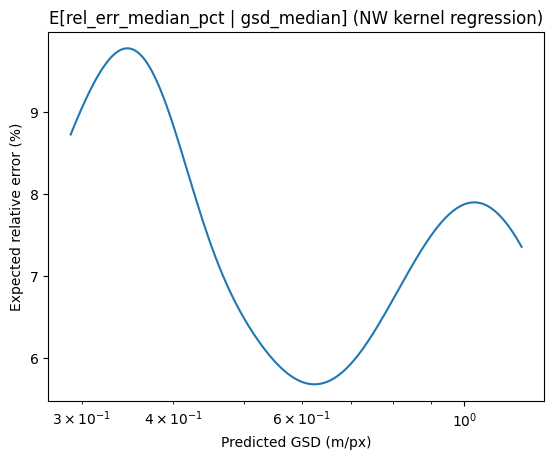

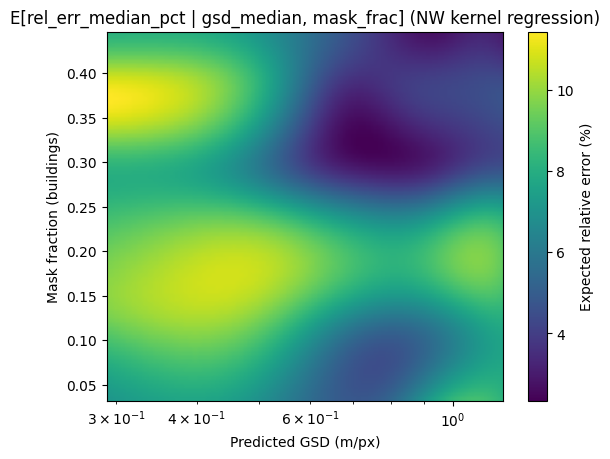

✅ Ready: f_err_from_gsd(gsd_hat) and f_err_from_gsd_and_mask(gsd_hat, mask_frac)


In [12]:
# ===== One-cell: continuous error surfaces vs predicted GSD (+ optional mask area fraction) =====
import os, numpy as np, pandas as pd, rasterio
import matplotlib.pyplot as plt

# -----------------------------
# 0) Assumptions / inputs
# -----------------------------
# You should already have:
# - df_detail (image x scale table) OR df (records) with columns:
#   image_name, pred_count, gsd_mean, gsd_median, rel_err_mean_pct, rel_err_median_pct
# - OUT_DIR pointing to dataset root with gt/ masks named same as images
# If your summary table is named differently, change df_base below.
df_base = df_detail.copy()  # <-- change to df.copy() if you want the other table

MASK_DIR = os.path.join(OUT_DIR, "gt")
USE_MEDIAN = True              # True: use gsd_median + rel_err_median_pct; False: mean versions
USE_WEIGHTS = True             # weight each row by pred_count (more windows -> more weight)
LOG_GSD = True                 # smooth in log(GSD) space (recommended)
# bandwidths: None = auto (Scott-like); you can set manually, e.g. BW_X=0.12
BW_X = None
BW_Z = None

# -----------------------------
# 1) mask_frac per image (fast proxy: fraction of building pixels on ORIGINAL mask)
# -----------------------------
def compute_mask_frac_table(mask_dir: str) -> pd.DataFrame:
    rows = []
    if not os.path.isdir(mask_dir):
        raise FileNotFoundError(f"Mask dir not found: {mask_dir}")
    for fn in sorted(os.listdir(mask_dir)):
        if not fn.lower().endswith((".tif", ".tiff")):
            continue
        p = os.path.join(mask_dir, fn)
        with rasterio.open(p) as ms:
            m = ms.read(1)
        frac = float(np.mean(m > 0))
        rows.append({"image_name": fn, "mask_frac": frac})
    return pd.DataFrame(rows)

mask_frac_df = compute_mask_frac_table(MASK_DIR)
df2 = df_base.merge(mask_frac_df, on="image_name", how="left")

# -----------------------------
# 2) Pick x (predicted GSD) and y (error), optional weights
# -----------------------------
x_col = "gsd_median" if USE_MEDIAN else "gsd_mean"
y_col = "rel_err_median_pct" if USE_MEDIAN else "rel_err_mean_pct"

x = df2[x_col].to_numpy(dtype=float)
y = df2[y_col].to_numpy(dtype=float)
mf = df2["mask_frac"].to_numpy(dtype=float)  # may contain NaN if merge missed
w = df2["pred_count"].to_numpy(dtype=float) if ("pred_count" in df2.columns and USE_WEIGHTS) else None

m = np.isfinite(x) & (x > 0) & np.isfinite(y)
if w is not None:
    m &= np.isfinite(w) & (w > 0)
# mask_frac can be missing; keep points anyway for 1D, but for 2D we’ll filter further
x, y = x[m], y[m]
mf_full = mf[m] if mf is not None else None
w = w[m] if w is not None else None

if LOG_GSD:
    x_t = np.log(np.clip(x, 1e-12, None))
else:
    x_t = x

# -----------------------------
# 3) Weighted Nadaraya–Watson kernel regression (continuous functions)
# -----------------------------
def _auto_bw_1d(u: np.ndarray) -> float:
    n = max(2, u.size)
    s = float(np.std(u))
    bw = 1.06 * s * (n ** (-1/5)) if s > 0 else 0.1
    return float(max(bw, 1e-3))

def _auto_bw_2d(u: np.ndarray) -> float:
    # Scott-like for 2D: n^(-1/(d+4)) with d=2 -> n^(-1/6)
    n = max(3, u.size)
    s = float(np.std(u))
    bw = 1.06 * s * (n ** (-1/6)) if s > 0 else 0.1
    return float(max(bw, 1e-3))

def nw_1d_func(x_train, y_train, w_train=None, bw=None):
    x_train = np.asarray(x_train, float)
    y_train = np.asarray(y_train, float)
    if w_train is None:
        w_train = np.ones_like(y_train, dtype=float)
    else:
        w_train = np.asarray(w_train, float)

    if bw is None:
        bw = _auto_bw_1d(x_train)

    def f(x_query):
        xq = np.asarray(x_query, float).reshape(-1)
        dx = (x_train[:, None] - xq[None, :]) / bw
        k = np.exp(-0.5 * dx * dx)  # gaussian
        ww = k * w_train[:, None]
        num = (ww * y_train[:, None]).sum(axis=0)
        den = ww.sum(axis=0) + 1e-12
        return (num / den).reshape(np.shape(x_query))

    return f, bw

def nw_2d_func(x_train, z_train, y_train, w_train=None, bw_x=None, bw_z=None):
    x_train = np.asarray(x_train, float)
    z_train = np.asarray(z_train, float)
    y_train = np.asarray(y_train, float)
    if w_train is None:
        w_train = np.ones_like(y_train, dtype=float)
    else:
        w_train = np.asarray(w_train, float)

    if bw_x is None:
        bw_x = _auto_bw_2d(x_train)
    if bw_z is None:
        bw_z = _auto_bw_2d(z_train)

    def f(x_query, z_query):
        xq = np.asarray(x_query, float).reshape(-1)
        zq = np.asarray(z_query, float).reshape(-1)
        dx = (x_train[:, None] - xq[None, :]) / bw_x
        dz = (z_train[:, None] - zq[None, :]) / bw_z
        k = np.exp(-0.5 * (dx*dx + dz*dz))
        ww = k * w_train[:, None]
        num = (ww * y_train[:, None]).sum(axis=0)
        den = ww.sum(axis=0) + 1e-12
        return num / den

    return f, (bw_x, bw_z)

# 1D: E[err | GSD_hat]
f1d, bw1d = nw_1d_func(x_t, y, w_train=w, bw=BW_X)

# 2D: E[err | GSD_hat, mask_frac] (only where mask_frac is finite)
m2 = np.isfinite(mf_full)
x2, y2, mf2 = x_t[m2], y[m2], mf_full[m2]
w2 = w[m2] if w is not None else None
f2d, (bw_x2, bw_z2) = nw_2d_func(x2, mf2, y2, w_train=w2, bw_x=BW_X, bw_z=BW_Z)

print("=== Fit info ===")
print(f"Points used (1D): {len(y)} | bw_x(logGSD)={bw1d:.4g} | weights={'pred_count' if w is not None else 'none'}")
print(f"Points used (2D): {len(y2)} | bw_x(logGSD)={bw_x2:.4g} bw_mask={bw_z2:.4g} | weights={'pred_count' if w2 is not None else 'none'}")

# -----------------------------
# 4) Quick plots
# -----------------------------
# 1D curve
xmin, xmax = np.nanmin(x), np.nanmax(x)
gsd_grid = np.geomspace(max(1e-6, xmin), xmax, 250)
xg = np.log(gsd_grid) if LOG_GSD else gsd_grid
err1 = f1d(xg)

plt.figure()
plt.plot(gsd_grid, err1)
plt.xscale("log")
plt.xlabel("Predicted GSD (m/px)")
plt.ylabel("Expected relative error (%)")
plt.title(f"E[{y_col} | {x_col}] (NW kernel regression)")
plt.show()

# 2D surface
if len(y2) >= 20:
    gmin, gmax = np.nanmin(x), np.nanmax(x)
    mmin, mmax = float(np.nanmin(mf2)), float(np.nanmax(mf2))
    G = np.geomspace(max(1e-6, gmin), gmax, 140)
    M = np.linspace(mmin, mmax, 90)
    GG, MM = np.meshgrid(G, M)
    XQ = np.log(GG.ravel()) if LOG_GSD else GG.ravel()
    Zhat = f2d(XQ, MM.ravel()).reshape(MM.shape)

    plt.figure()
    plt.imshow(Zhat, aspect="auto", origin="lower",
               extent=[G.min(), G.max(), M.min(), M.max()])
    plt.xscale("log")
    plt.xlabel("Predicted GSD (m/px)")
    plt.ylabel("Mask fraction (buildings)")
    plt.title(f"E[{y_col} | {x_col}, mask_frac] (NW kernel regression)")
    plt.colorbar(label="Expected relative error (%)")
    plt.show()
else:
    print("Not enough points with finite mask_frac for a stable 2D surface (need ~20+).")

# -----------------------------
# 5) Export callable “continuous functions”
# -----------------------------
# f_err_from_gsd(gsd_hat) -> expected error (%)
def f_err_from_gsd(gsd_hat):
    gsd_hat = np.asarray(gsd_hat, float)
    xq = np.log(np.clip(gsd_hat, 1e-12, None)) if LOG_GSD else gsd_hat
    return f1d(xq)

# f_err_from_gsd_and_mask(gsd_hat, mask_frac) -> expected error (%)
def f_err_from_gsd_and_mask(gsd_hat, mask_frac):
    gsd_hat = np.asarray(gsd_hat, float)
    mask_frac = np.asarray(mask_frac, float)
    xq = np.log(np.clip(gsd_hat, 1e-12, None)) if LOG_GSD else gsd_hat
    return f2d(xq.reshape(-1), mask_frac.reshape(-1)).reshape(np.broadcast(gsd_hat, mask_frac).shape)

print("✅ Ready: f_err_from_gsd(gsd_hat) and f_err_from_gsd_and_mask(gsd_hat, mask_frac)")
